# IRRmodel\*WCM calibration with PSO on KGE of $\sigma^0$

The v5 code is a final, cleaned and commented version.

## Temporal resolution of inputs parameters and calibration
The input datasets can have different temporal resolutions:
- hourly
- daily
- multi-daily

platinum_df tables of Budrio's SWC, rain and irrigation are hourly.
Climate data such as ET and PET are daily. 
Sigma0 values are daily and multi-daily.
NDVI, LAI and other satellite products are multi-daily.

In order to be self-consistent, the model must be calibrated by taking
into account the temporal scale of variation of quantities.
In particular, the soil water balance (SWB) model requires inputs
that can be hourly or daily. Hourly data have to resampled to be
consistent with daily ones, so SWC, rain and irrigation have to be taken
as their mean and sum values. In this way consistency with ET or PET is
ensured.
Once the SWB model has provided daily values, they can be used as inputs in
the water cloud model, that is calibrated against sigma0 values.

It is clear that an optimal calibration would require an hourly SWB estimate
to match with the correct hours of passage of the satellite. On the other
hand, this would require hourly interpolation of ET and PET data. Moreover, at the
moment the computational power required for such a procedure is not possible
to estimate.

In [710]:
import sys
sys.path.append('../')

from modules.funcs import *
from modules.funcs_pso import *
# from modules.pyeto import *

# KEEP YOUR MODELS IN THE NOTEBOOK UNTIL THEY ARE PERFECT
# CAUSE EXTERNAL IMPORT IS AWFUL IN JUPYTER
# from IRRI_WCM.IRRI_WCM_model import *

In [711]:
def pso_calib_irri(PAR):
    """Ausiliary function for PSO optimization"""
    global inputs
    global irri
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        WW,IRR,sig0,KGE = IRR_WCM(PAR[i], inputs, user_in)
        err[i] = 1 - KGE
    return err

# WCM

In [712]:
def WCM(PAR, data_in, units='lin'):
    """Water Cloud Model.
    
    This function simulates backscattering with WCM and returns
    the KGE index to perform its minimization for calibration
    of parameters A,B,C,D.
    WCM is parametrized with a single vegetation descriptor (nominated
    veg, but can be anything).
    Fitting can be performed in linear or dB scale.
    
    
    Inputs
    ------
    - PAR: list
        List of initial guesses for the parameters to calibrate.
    - data_in: list
        List of inputs of observables, that must be in the form:
        [SM,veg,t_deg,obs], being SM = soil moisture,
        veg = Leaf Area Index, t_deg = angle of observation,
        obs = observed total sigma0
    - units: str, default 'linear'
        choose to calibrate the model's parameters in 'linear' or 'db' scale
        
    Return
    ------
    KGE between simulated and observed backscattering.
    
    """

    A,B,C,D = PAR # parameters to fit
    SM,veg,t_deg,obs = data_in # input data
    
    theta = t_deg*np.pi/180. # angle of observation
    sig0s_dB = C+D*SM # sigma0_soil [dB]
    T2 = np.exp((-2*B*veg)/np.cos(theta)) # attenuation
    
    if units=='lin':
        sig0s = db_lin(sig0s_dB) # sigma0_soil [lin]
        sig0v = A*veg*np.cos(theta)*(1-T2) # sigma0_veg [lin]
        sig0_lin = T2*sig0s+sig0v # sigma0_tot [lin]
        sig0=lin_db(sig0_lin) # sigma0_tot [dB]
    elif units=='db':
        sig0v = A*veg*np.cos(theta)*(1-T2) # sigma0_veg [db]
        sig0 = T2*sig0s+sig0v # sigma0_tot [db]
    else: raise NameError('Please choose one of the options: linear/db')
        
    OUT=he.evaluator(he.kge, sig0, obs) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];

    return [sig0,KGE]

#----------------------------------------------------------------------------

def SM_fromWCM(PAR, data_in, units='lin'):
    """Inverted WCM for SM estimation."""

    A,B,C,D = PAR # parameters, fitted
    SM,veg,t_deg,obs = data_in # input data
    
    theta = t_deg*np.pi/180. # angle of observation
    T2 = np.exp((-2*B*veg)/np.cos(theta)) # attenuation
    sig0v = A*veg*np.cos(theta)*(1-T2) # sigma0_veg
    
    if units=='lin':
        sig0s_lin = (db_lin(obs)-sig0v)/T2
        SMretr = (lin_db(sig0s_lin)-C)/D
    elif units=='db':
        sig0s = (obs-sig0v)/T2
        SMretr = (sig0s-C)/D 
    
    OUT=he.evaluator(he.kge, SMretr, SM) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];

    return [SMretr,KGE]

# IRRI+WCM

In [713]:
def IRR_WCM(PAR, inputs, user_in):
    """Irrigation model and WCM integration.
    
    Based on minimization of KGE between observed and simulated
    $\sigma^0$ values via PSO (pyswarm) optimization.
    The soil water balance model (IRR) produces an estimate of the soil water
    content WW [%] that is used to simulate $\sigma^0$ by a water cloud
    model (WCM).
    
    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs: input quantities for calibration,
        [d, d_sat, P, IRR_obs, EPOT, WWobs, LAI, t_deg, obs]
    - user_in: user-defined options
        irri = user_in: if user_in=True, irrigation is estimated
        and not taken as an input, else the input observed irrigation
        is used in the soil water balance
    
    Return
    -------
    KGE from hydroeval between sigma0 observed and simulated.
    
    """

    # User input
    irri, units = user_in
    
    # Unpack inputs
    A, B, C, D, W_0, W_max, WW_fc, WW_w, rho_st, Kc = PAR
    d, d_sat, P, IRR_obs, EPOT, W_d, W_h, veg, theta, VV = inputs
    
    # Fixed parameters
    W_0 = W_d[0]
    WW_fc = 0.32
    WW_w = 0.08
    rho_st = 0.4    
    
    angle = theta*np.pi/180. # angle of incidence
    W_fc = WW_fc*W_max # field capacity [mm]
    W_w = WW_w*W_max # wilting point [mm]
    Ks = [0]*len(d) # daily, water stress coefficient
    rho = [0]*len(d) # daily, depletion fraction
    PS = [0]*len(d) # daily, deep percolation
    W = [0]*len(d) # daily, water content [mm]
    W[0] = W_0*W_max # initial value of sm [mm]
    if irri==True: IRR = [0]*len(d) # daily, water content
    else: IRR = IRR_obs
    
    for t in [i+1 for i in range(len(d)-1)]:
        rho[t]=rho_st+0.04*(5-Kc*EPOT[t])
        if W[t-1]>=(1-rho[t])*W_fc:
            Ks[t]=1
        elif (W[t-1]>W_w)and(W[t-1]<(1-rho[t])*W_fc):
            Ks[t]=float(W[t-1]-W_w)/((1-rho[t])*(W_fc-W_w))
        else: Ks[t]=0
        
        DOY=d[t].dayofyear
        
        # Irrigation estimate (for summer season only)
        # Irrigation is estimated as the amount of water needed from the day
        # before to take water content up to field capacity
        if irri==True:
            if np.logical_and(DOY>134,DOY<235): # summer season
                if W[t-1]<=(1-rho[t])*W_fc: IRR[t]=W_fc-W[t-1]
        
        # Water balance [mm]
        W[t]=W[t-1]+P[t]+IRR[t]-EPOT[t]*Kc*Ks[t]
        
        # Computation of deep percolation (water above field capacity)
        if W[t]>W_fc:
            PS[t]=W[t]-W_fc
            W[t]=W_fc
            
    WW=np.array(W)/W_max
    
    #------------------------------------------------------------------------
    # print('\n----------check----------')
    # print(pd.DataFrame(WW).describe())
    #------------------------------------------------------------------------

    WWsat = pd.DataFrame(timeseries(d,WW)).set_index(0).loc[d_sat][1].values
    
    
    sig0s_dB = C+D*WWsat # sigma0_soil [dB]
    T2 = np.exp((-2*B*veg)/np.cos(angle)) # attenuation
    
    if units=='lin':
        sig0s = db_lin(sig0s_dB) # sigma0_soil [lin]
        sig0v = A*veg*np.cos(angle)*(1-T2) # sigma0_veg [lin]
        sig0_lin = T2*sig0s+sig0v # sigma0_tot [lin]
        sig0=lin_db(sig0_lin) # sigma0_tot [dB]
    elif units=='db':
        sig0v = A*veg*np.cos(angle)*(1-T2) # sigma0_veg [db]
        sig0 = T2*sig0s+sig0v # sigma0_tot [db]
    else: raise NameError('Please choose one of the options: lin/db')

    
    # T2 = np.exp((-2*B*veg)/np.cos(angle)) # two-way attenuation from the vegetation layer
    # sig0s = db_lin(C+D*WWsat) # define bare soil backscatter [fit in dB, then in lin]
    # sig0v = A*veg*np.cos(angle)*(1-T2) # define backscatter from the vegetation [fit in lin]
    # sig0_lin = T2*sig0s+sig0v
    # sig0=lin_db(sig0_lin) # from linear scale to dB
        
    OUT=he.evaluator(he.kge, sig0, VV) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];

    return [WW,IRR,sig0,KGE]

# Global

In [714]:
filename = f'irr_obs_'

# Data pre-processing

Input data formatting convention:
- ausiliary variables for extraction of data (directory name, file name, etc...)
- extraction into pd dataframe
- cleaning, resampling: drop unnecessary columns, set index to daily DateIndex

**Time resampling consistency**

- $\sigma^0$ values are extracted with a timestamp aaaa-mm-dd hh:mm:ss with frequency 'H' (hourly), then are rounded by `.round()` to the midnight of the nearest day to have frequency 'D' (daily), e.g. a passage at 7 am on 1st july is rounded to 0 am of 1st july, a passage at 7 pm would be rounded at 0 am of 2nd july.
- many quantities need to be resampled from hourly to daily datasets: use the `.resample()` method on a dataframe with hourly DatetimeIndex and pass the argument `origin='end_day'`. In this way, for each day X, data are considered between hours 1 and 24(=0 of day X+1) and the timestamp assigned is the one of the day X+1 (on which the operation ends). 

In [715]:
print('Starting...\n'
      +'#-------------------------------------------------------------\n'
      #+'Use of satellite-derived SM is provided for comparison, not calibration.\n'
     )
verbose = True if input("Verbose data extraction? (Describe datasets/files) [y/n]")=='y' else False

params = []; norma = ''

print('\n#-------------SWB model parameters-------------')
irri = True if input('Do you want to calibrate irrigation as well as soil moisture? '
                     +'Answer yes will treat irrigation observations as a benchmark '
                     +'for model performance only. [[]/(any)')=='' else False
year = int(input('Do you want to calibrate on year 2017 or 2020? [2017/2020]'))

print('\n#-------------WCM model parameters-------------')
units = input('Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db]')


print('\n#------------Optimization parameters-----------')
nrun = int(input('Number of runs? (10 is min to study distribution of parameters.) '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norma = 1 if input('Which norm? [l1/l2] ')=='l1' else 2
verbose = True if input('Verbose? [[]/(any)]')=='' else False

Starting...
#-------------------------------------------------------------



Verbose data extraction? (Describe datasets/files) [y/n] y



#-------------SWB model parameters-------------


Do you want to calibrate irrigation as well as soil moisture? Answer yes will treat irrigation observations as a benchmark for model performance only. [[]/(any) n
Do you want to calibrate on year 2017 or 2020? [2017/2020] 2020



#-------------WCM model parameters-------------


Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db] lin



#------------Optimization parameters-----------


Number of runs? (10 is min to study distribution of parameters.)  1
Number of particles:  20
Number of optimization steps:  100
Global or Local PSO optimizer? [[global]/local]  
Verbose? [[]/(any)] 


## IRRmodel

Frequency: daily

Inputs:
- rain (sum, end of day)
- et0 (daily)

Comparisons:
- irrigation (sum, end of day)
- soil moisture (mean, end of day)

In [716]:
#----------------------------------------------------------------------------
# Field data from TEST_SITE
# Daily data from 2015 to 2017, various gaps

# Data extracted:
# - rain (as input SWB)
# - EPOT = potential evapotranspiration (as input SWB)

namesite = 'ITALY_BUDRIO'
siteID = '5'
namefig = namesite+'_'+siteID

site_df = xr.open_dataset(f'..\Inputs\TEST_SITE\TEST_SITE_{namesite}.nc',
                         engine='netcdf4').to_dataframe();
site_df = site_df.rename(columns={'Time_days':'Date'})
site_df = site_df.set_index('Date')
site_df = site_df.loc[:,[col for col in site_df.columns if col.endswith(siteID)]]
if verbose: site_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1037 entries, 2015-01-01 to 2017-11-02
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Irrigation_5        214 non-null    float64
 1   Rainfall_5          1037 non-null   float64
 2   ET_5                1037 non-null   float64
 3   PET_5               1037 non-null   float64
 4   SSM_ASCAT_5         1009 non-null   float64
 5   SSM_CCI_combined_5  998 non-null    float64
 6   SSM_CCI_active_5    972 non-null    float64
 7   SSM_CCI_passive_5   925 non-null    float64
 8   SSM_SMAP_5          609 non-null    float64
 9   SSM_SMOS_5          598 non-null    float64
 10  SSM_THEIA_5         179 non-null    float64
 11  SSM_RT1_5           241 non-null    float64
dtypes: float64(12)
memory usage: 105.3 KB


In [717]:
#----------------------------------------------------------------------------
# Budrio field data from platinum_df tables

# Freq: H
# Data extracted:
# - SWC (as input SWB/comparison)
# - rain (as input SWB)
# - irrigation (as input SWB)
# - temperature (as input SWB, ET0 estimate)

platinum_df = pd.ExcelFile('..\Inputs\Platinum_Budrio.xlsx', engine='openpyxl')
if year==2017: sheet='2017_1h'
if year==2020: sheet='2020_1h'
platinum_df = platinum_df.parse(sheet)
# platinum_df = pd.concat([platinum_df.parse('2017_1h'), platinum_df.parse('2020_1h')])

# Column 'Date' contains date+hour = hourly information
# Column 'Data' contains only date = daily information
platinum_df['Ora_1'] = pd.to_datetime(platinum_df['Ora'].astype('str')).apply(lambda x: x.time())
platinum_df['Data_1'] = pd.to_datetime(platinum_df['Data'].astype('str')).apply(lambda x: x.date())
platinum_df['Datetime'] = platinum_df.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum_df = platinum_df.drop(['ID', 'Data', 'Ora', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)
platinum_df = platinum_df.set_index('Datetime')
platinum_resampled = platinum_df.resample('D', origin='end_day')
if verbose: platinum_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4349 entries, 2020-03-04 16:00:00 to 2020-09-01 20:00:00
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SWC[m3/m3]       4004 non-null   float64
 1   Pioggia[mm]      4349 non-null   float64
 2   Irrigazione[mm]  4349 non-null   float64
 3   Temperatura[°C]  4348 non-null   float64
dtypes: float64(4)
memory usage: 169.9 KB


In [718]:
#----------------------------------------------------------------------------
# Budrio field data from meteo tables

# Freq: H
# Data extracted:
# none
# Needed for eto from FAO PM 

meteo_df = pd.ExcelFile('..\Inputs\Budrio_Meteo.xlsx', engine='openpyxl')
meteo_df = meteo_df.parse(str(year))
# meteo_df = pd.concat([meteo_df.parse('2017'), meteo_df.parse('2020')]).set_index('ID')

# Column 'Date' contains date+hour = hourly information
meteo_df['Datetime'] = meteo_df.apply(lambda r : dtt.datetime.combine(r['Data'],r['Ora']),1)
meteo_df = meteo_df.set_index('Datetime')
meteo_df = meteo_df.drop(['Data', 'Ora'],axis=1)

if verbose: meteo_df.info()
# meteo_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4350 entries, 2020-03-04 15:00:00 to 2020-09-01 20:00:00
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             4350 non-null   int64  
 1   Raffica di vento [m/s]         4349 non-null   float64
 2   Radiazione solare [W/m2]       4349 non-null   float64
 3   Direzione del vento [°]        4349 non-null   float64
 4   Radiazione UV [MED]            4349 non-null   float64
 5   Velocità del vento [m/s]       4349 non-null   float64
 6   Pressione atmosferica [hPa]    4349 non-null   float64
 7   Punto di rugiada [C°]          4349 non-null   float64
 8   Temperatura Aria [C°]          4349 non-null   float64
 9   Umidità aria [%]               4349 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 373.8 KB


In [719]:
# Budrio database
# Freq: H
# Merging of Platinum+Meteo

meteo_h = pd.merge(right=platinum_df, left=meteo_df, on='Datetime')
if verbose: meteo_h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4349 entries, 2020-03-04 16:00:00 to 2020-09-01 20:00:00
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             4349 non-null   int64  
 1   Raffica di vento [m/s]         4348 non-null   float64
 2   Radiazione solare [W/m2]       4348 non-null   float64
 3   Direzione del vento [°]        4348 non-null   float64
 4   Radiazione UV [MED]            4348 non-null   float64
 5   Velocità del vento [m/s]       4348 non-null   float64
 6   Pressione atmosferica [hPa]    4348 non-null   float64
 7   Punto di rugiada [C°]          4348 non-null   float64
 8   Temperatura Aria [C°]          4348 non-null   float64
 9   Umidità aria [%]               4348 non-null   float64
 10  SWC[m3/m3]                     4004 non-null   float64
 11  Pioggia[mm]                    4349 non-null   float64
 12  Irrigazione[

After long and deep thinking \
and at least ten coffee drinking \
I have reached the conclusion \
that the best possible solution \
for the inputs' database \
is in fact the easiest case: \
take each column as it is, \
resample, sum or take the mean, \
give a name to every one \
and please take it easy for once!

In [720]:
# Build inputs as timeseries (using the nominal function)
# timeseries(dates, data) -> matrix[columns={dates, data}]

In [721]:
# ET0 calculation

import datetime
import sys

sys.path.append('../')
from modules.pyeto.pyeto import *

def hargre(lat_deg, dates, temp_min, temp_max, temp_mean):
    """Hargreaves-Samani model for ET0 estimation from temperature input.
    
    Params
    ------
    - lat_deg: float
    - dates: timestamp
    - temp_*: float
    
    
    """
    lat = deg2rad(lat_deg)  # Convert latitude in degrees to radians
    day_of_year = dates.dayofyear
    sol_decli = sol_dec(day_of_year) # Solar declination
    sha = sunset_hour_angle(lat, sol_decli)
    ird = inv_rel_dist_earth_sun(day_of_year)
    et_radia = et_rad(lat, sol_decli, sha, ird) # Extraterrestrial radiation
    return hargreaves(temp_min, temp_max, temp_mean, et_radia)

In [722]:
from IRRI_WCM.EPOT_Hargreaves_pyeto import *

lat_deg = 44.570842547510622 # latitude of Budrio (deg)
temp_min = platinum_resampled.min()['Temperatura[°C]'].values
temp_max = platinum_resampled.max()['Temperatura[°C]'].values
temp_mean = platinum_resampled.mean()['Temperatura[°C]'].values
dates = platinum_resampled.asfreq().index
eto = timeseries( dates,
                 [ hargre(lat_deg, dates[i] , temp_min[i], temp_max[i], temp_mean[i])
                  for i in range(len(dates)) ] )
eto_df = pd.DataFrame(eto).rename(columns={0:'Date',1:'EPOT'}).set_index('Date')
if verbose: eto_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182 entries, 2020-03-05 to 2020-09-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EPOT    182 non-null    float64
dtypes: float64(1)
memory usage: 2.8 KB


## WCM

Frequency: multi-daily

Inputs:
- $\sigma^0$, $\theta$ (hourly, rounded to nearest midnight)
- vegetation descriptors (NDVI, LAI, CR) (average, daily)

In [723]:
#----------------------------------------------------------------------------
# Sigma0 values

# Freq: D
# Daily values of backscattering from 2014 to 2022 (complete S1 series)
# Data extracted:
# - sigma0 values, VV and VH
# - angle of incidence of reference orbit (nearest to 40°)

sigma_df = pd.read_csv('..\Data\\budrio-half.csv', delimiter='\t');
sigma_df['Datetime'] = sigma_df.Date.apply(lambda x : pd.to_datetime(x))
sigma_df.Date = sigma_df.Date.apply(lambda x : pd.to_datetime(x).round(freq='D'))
sigma_df = sigma_df.set_index('Date')
if verbose: sigma_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1150 entries, 2014-10-12 to 2022-11-28
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Angle[°]     1150 non-null   float64       
 1   Geometry     1150 non-null   object        
 2   Orb          1150 non-null   int64         
 3   Pass         1150 non-null   object        
 4   VV_norm[dB]  1150 non-null   float64       
 5   VH_norm[dB]  1150 non-null   float64       
 6   CR           1150 non-null   float64       
 7   Datetime     1150 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 80.9+ KB


In [724]:
#----------------------------------------------------------------------------
# NDVI values

# Freq: D
# Daily values of NDVI from 2017-4-24 to 2023-1-13 (complete S2 series)
# Data extracted:
# - NDVI (daily, interpolated)

ndvi_df = pd.read_csv('..\Data\\budrio-half_NDVI.csv', delimiter='\t');
ndvi_df.Date = ndvi_df.Date.apply(lambda x : pd.to_datetime(x))
ndvi_df = ndvi_df.set_index('Date')
if verbose: ndvi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2091 entries, 2017-04-24 to 2023-01-13
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NDVI      2091 non-null   float64
 1   Geometry  2091 non-null   object 
dtypes: float64(1), object(1)
memory usage: 49.0+ KB


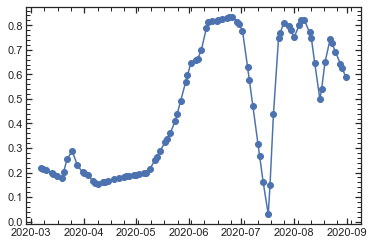

In [744]:
plt.plot(ndvi_df.loc[d_sat].NDVI, marker='o')

## Input data

In [725]:
# Input SWB
# Frequency: daily
# Data:
# - rain (sum, end of day) from platinum_resampled
# - eto (daily) from eto_df

input_swb = pd.merge(right=eto_df, left=platinum_resampled.sum(),
                     right_on='Date', left_on='Datetime', right_index=True)\
                    .drop(['SWC[m3/m3]','Temperatura[°C]'], axis=1)\
                    .rename(columns={'Pioggia[mm]':'Pioggia[mm]_sum',
                                     'Irrigazione[mm]':'Irrigazione[mm]_sum'})
swc = platinum_resampled.mean()['SWC[m3/m3]']
input_swb['SWC[m3/m3]_mean'] = swc
if verbose: input_swb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182 entries, 2020-03-05 to 2020-09-02
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Pioggia[mm]_sum      182 non-null    float64
 1   Irrigazione[mm]_sum  182 non-null    float64
 2   EPOT                 182 non-null    float64
 3   SWC[m3/m3]_mean      173 non-null    float64
dtypes: float64(4)
memory usage: 7.1 KB


In [726]:
# Input WCM
# Frequency: daily
# Data:
# - sigma0 (multi-daily, rounded at nearest midnight)
# - NDVI (daily, interpolated)
# Merging is performed without any time offset, considering that the change
# in ndvi values anywhere is very small from one day to another 

input_wcm_sat = pd.merge(right=sigma_df, left=ndvi_df, on='Date', how='right')

In [727]:
input_wcm_sat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1150 entries, 2014-10-12 to 2022-11-28
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   NDVI         916 non-null    float64       
 1   Geometry_x   916 non-null    object        
 2   Angle[°]     1150 non-null   float64       
 3   Geometry_y   1150 non-null   object        
 4   Orb          1150 non-null   int64         
 5   Pass         1150 non-null   object        
 6   VV_norm[dB]  1150 non-null   float64       
 7   VH_norm[dB]  1150 non-null   float64       
 8   CR           1150 non-null   float64       
 9   Datetime     1150 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 98.8+ KB


In [728]:
input_wcm = pd.merge(right=input_wcm_sat, left=platinum_df, on='Datetime',
                     how='inner')\
            .drop(['Pioggia[mm]','Irrigazione[mm]','Temperatura[°C]',
                   'Geometry_x'], axis=1)\
            .rename(columns={'SWC[m3/m3]':'SWC_h', 'Geometry_y':'Geometry',
                             'VV_norm[dB]':'VV', 'VH_norm[dB]':'VH', 'Angle[°]':'Angle'})

#----------------------------------------------------------------------------
# Convenience method for printing labels of columns that are interpolated
# only on the basis of their length being less than the length of the df,
# and not taking into consideration if they are being interpolated or extr

# print('The following columns will be interpolated: '
#       +f'{[x for x in input_wcm if len(input_wcm[x].dropna())<len(input_wcm)]}\n')

print('The following columns will be interpolated: NDVI')
if input('Proceed? [y/n]')!='y':
     raise NameError('Stop and stare! I think I\'m going but I don\'t know where!')
#----------------------------------------------------------------------------

# NDVI values are limited below at the 24 of april 2017, so they are
# backward propagated for 30 days in order to cover the whole Budrio period.
# Altough there is a gap in SWC values, this gap is mantained since its
# presence is to be taken into account separately only when calibrating
# the WCM alone with in-situ data.
input_wcm.NDVI.interpolate(method='bfill',
                           limit_direction='backward',
                           limit=30,
                           # limit_area='inside', # THIS WORKS VERY BADLY IN EVERY WAY
                           inplace=True)

input_wcm.index = input_wcm.Datetime.round('D')
if verbose: input_wcm.info()

The following columns will be interpolated: NDVI


Proceed? [y/n] y


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88 entries, 2020-03-07 to 2020-08-31
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  88 non-null     datetime64[ns]
 1   SWC_h     80 non-null     float64       
 2   NDVI      88 non-null     float64       
 3   Angle     88 non-null     float64       
 4   Geometry  88 non-null     object        
 5   Orb       88 non-null     int64         
 6   Pass      88 non-null     object        
 7   VV        88 non-null     float64       
 8   VH        88 non-null     float64       
 9   CR        88 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 7.6+ KB


In [729]:
# List of 2017 and 2020 dates

# Complete days in 2017, 2020
d = [x for x in input_swb.index if x.year==year]
     
# Days of passage of satellite, intersect with complete days
set1 = {x for x in input_swb.index}; set2 = {x for x in input_wcm.index};
intersect = np.sort(np.array([*set1.intersection(set2)]))
d_sat = [x for x in intersect if x.year==year]
h_sat = [x for x in input_wcm.Datetime if x.year==year]

In [730]:
P       = input_swb.loc[d]['Pioggia[mm]_sum'] # [mm]
IRR_obs = input_swb.loc[d]['Irrigazione[mm]_sum'] # [mm]
EPOT    = input_swb.loc[d]['EPOT'] # [mm/day]
WW_d    = input_swb.loc[d]['SWC[m3/m3]_mean'] # daily, mean (observed) [m3/m3]
WW_h    = input_wcm.loc[d_sat]['SWC_h'] # punctual at hour (observed) [m3/m3]
veg     = input_wcm.loc[d_sat]['NDVI'] # [-]
theta   = input_wcm.loc[d_sat]['Angle'] # [°]
VV      = input_wcm.loc[d_sat]['VV'] # [dB]
VH      = input_wcm.loc[d_sat]['VH'] # [dB]
CR      = input_wcm.loc[d_sat]['CR'] # [-]

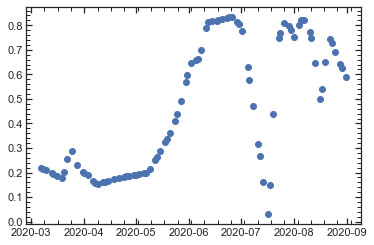

In [731]:
plt.plot(veg, ls='', marker='o')

# Calibration SWB+WCM

In [732]:
print('Starting calibration...\n'+
      '#-------------------------------------------------------------\n')

A=0.1; B=0.1; C=-10; D=3 # guess params for WCM
W_0=      0.1;  # [mm] water content, initial
W_max=    80;   # [mm] water content, maximum (not normalized)
WW_fc=    0.32; # [m3/m3] water content at field capacity
WW_w=     0.08; # [m3/m3] water content at wilting point
rho_st=   0.7;  # [-] crop specific depletion fraction
Kc=       0.4;  # [-] crop specific coefficient

PAR     = [A, B, C, D, W_0, W_max, WW_fc, WW_w, rho_st, Kc]
inputs  = [d, d_sat, P, IRR_obs, EPOT, WW_d, WW_h, veg, theta, VV]
user_in = [irri, units]

if units=='lin':
    bounds = (
        np.array([.01, .01, -35, 1, 0.01, 100, .32, .01, .5, .3]), # # low
        np.array([  5,  10,   0, 60, 0.5, 500, .95, .45, .8, .6]), # # up
    )
elif units=='db':
    bounds = (
        np.array([ -15, .01, -35, 1, 0.01, 100, .32, .01, .5, .3]), # # low
        np.array([-0.1,  10,   0, 60, 0.5, 500, .95, .45, .8, .6]), # # up
    )
else: raise NameError(f'Scale can only be lin or db but {scale} was provided.')

#-----------------------------------------------------------------------------
from pyswarms.backend.handlers import OptionsHandler

for i in range(int(nrun)):
    if (optim=='global')or(optim==''):
        # options = {'c1': 0.5, 'c2': 0.9, 'w': 0.6}
        options = {'c1': 2.05, 'c2': 2.05, 'w': 0.1}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles),
                                            dimensions=len(PAR),
                                            options=options,
                                            bounds=bounds,
                                            # oh_strategy={"w":'exp_decay',
                                            #              'c1':'lin_variation',
                                            #              'c2':'lin_variation'}
                                           )
    elif optim=='local':
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norma }
        optimizer = ps.single.LocalBestPSO(n_particles=n_particles,
                                           dimensions=len(PAR),
                                           options=options,
                                           bounds=bounds)
    else: raise NameError('Please provide an accepted option.')
    
    cost, PARn = optimizer.optimize(pso_calib_irri, n_step, verbose=verbose)#, **PAR)
    params.append(PARn)
    i+=1

#-----------------------------------------------------------------------------
# Model validation
#-----------------------------------------------------------------------------
WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)
print('PAR = [A, B, C, D, W_0, W_max, W_fc, W_w, rho_st, Kc]\n', PARn)
timestr = time.strftime("%y%m%d-%H%M%S")

#-----------------------------------------------------------------------------
# Study distribution of parameters
#-----------------------------------------------------------------------------
matrix = np.array([ np.array([ params[i][j] for i in range(len(params)) ])
        for j in range(len(params[0])) ])

if (int(nrun)>9)and(input('Plot parameters distributions? [y/n]')=='y'):
    for i in range(len(matrix)):
        plt.hist(matrix[i])
        plt.show()

2023-01-18 18:47:43,218 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.1}


Starting calibration...
#-------------------------------------------------------------



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|100/100, best_cost=0.459
2023-01-18 18:48:12,422 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4585266429928252, best pos: [  0.19652456   0.58113369 -19.02946874  36.66799289   0.28206223
 131.81743033   0.41778844   0.35759829   0.76846826   0.43813767]


PAR = [A, B, C, D, W_0, W_max, W_fc, W_w, rho_st, Kc]
 [  0.19652456   0.58113369 -19.02946874  36.66799289   0.28206223
 131.81743033   0.41778844   0.35759829   0.76846826   0.43813767]


# Calibration WCM

In [732]:
print('Starting calibration...\n'+
      '#-------------------------------------------------------------\n')

A=0.1; B=0.1; C=-10; D=3 # guess params for WCM
W_0=      0.1;  # [mm] water content, initial
W_max=    80;   # [mm] water content, maximum (not normalized)
WW_fc=    0.32; # [m3/m3] water content at field capacity
WW_w=     0.08; # [m3/m3] water content at wilting point
rho_st=   0.7;  # [-] crop specific depletion fraction
Kc=       0.4;  # [-] crop specific coefficient

PAR     = [A, B, C, D]
inputs  = [d, d_sat, P, IRR_obs, EPOT, WW_d, WW_h, veg, theta, VV]
user_in = [irri, units]

if units=='lin':
    bounds = (
        np.array([.01, .01, -35, 1, 0.01, 100, .32, .01, .5, .3]), # # low
        np.array([  5,  10,   0, 60, 0.5, 500, .95, .45, .8, .6]), # # up
    )
elif units=='db':
    bounds = (
        np.array([ -15, .01, -35, 1, 0.01, 100, .32, .01, .5, .3]), # # low
        np.array([-0.1,  10,   0, 60, 0.5, 500, .95, .45, .8, .6]), # # up
    )
else: raise NameError(f'Scale can only be lin or db but {scale} was provided.')

#-----------------------------------------------------------------------------
from pyswarms.backend.handlers import OptionsHandler

for i in range(int(nrun)):
    if (optim=='global')or(optim==''):
        # options = {'c1': 0.5, 'c2': 0.9, 'w': 0.6}
        options = {'c1': 2.05, 'c2': 2.05, 'w': 0.1}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles),
                                            dimensions=len(PAR),
                                            options=options,
                                            bounds=bounds,
                                            # oh_strategy={"w":'exp_decay',
                                            #              'c1':'lin_variation',
                                            #              'c2':'lin_variation'}
                                           )
    elif optim=='local':
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norma }
        optimizer = ps.single.LocalBestPSO(n_particles=n_particles,
                                           dimensions=len(PAR),
                                           options=options,
                                           bounds=bounds)
    else: raise NameError('Please provide an accepted option.')
    
    cost, PARn = optimizer.optimize(pso_calib_irri, n_step, verbose=verbose)#, **PAR)
    params.append(PARn)
    i+=1

#-----------------------------------------------------------------------------
# Model validation
#-----------------------------------------------------------------------------
WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)
print('PAR = [A, B, C, D, W_0, W_max, W_fc, W_w, rho_st, Kc]\n', PARn)
timestr = time.strftime("%y%m%d-%H%M%S")

#-----------------------------------------------------------------------------
# Study distribution of parameters
#-----------------------------------------------------------------------------
matrix = np.array([ np.array([ params[i][j] for i in range(len(params)) ])
        for j in range(len(params[0])) ])

if (int(nrun)>9)and(input('Plot parameters distributions? [y/n]')=='y'):
    for i in range(len(matrix)):
        plt.hist(matrix[i])
        plt.show()

2023-01-18 18:47:43,218 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.1}


Starting calibration...
#-------------------------------------------------------------



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|100/100, best_cost=0.459
2023-01-18 18:48:12,422 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4585266429928252, best pos: [  0.19652456   0.58113369 -19.02946874  36.66799289   0.28206223
 131.81743033   0.41778844   0.35759829   0.76846826   0.43813767]


PAR = [A, B, C, D, W_0, W_max, W_fc, W_w, rho_st, Kc]
 [  0.19652456   0.58113369 -19.02946874  36.66799289   0.28206223
 131.81743033   0.41778844   0.35759829   0.76846826   0.43813767]


# Model output

# Plot

Save simulated VS observed soil moisture? [[]/(any)] n


RMSE = 0.07045755718539436
NS = -1.3678116722127385
R (sim vs obs) = 0.6472852772638875


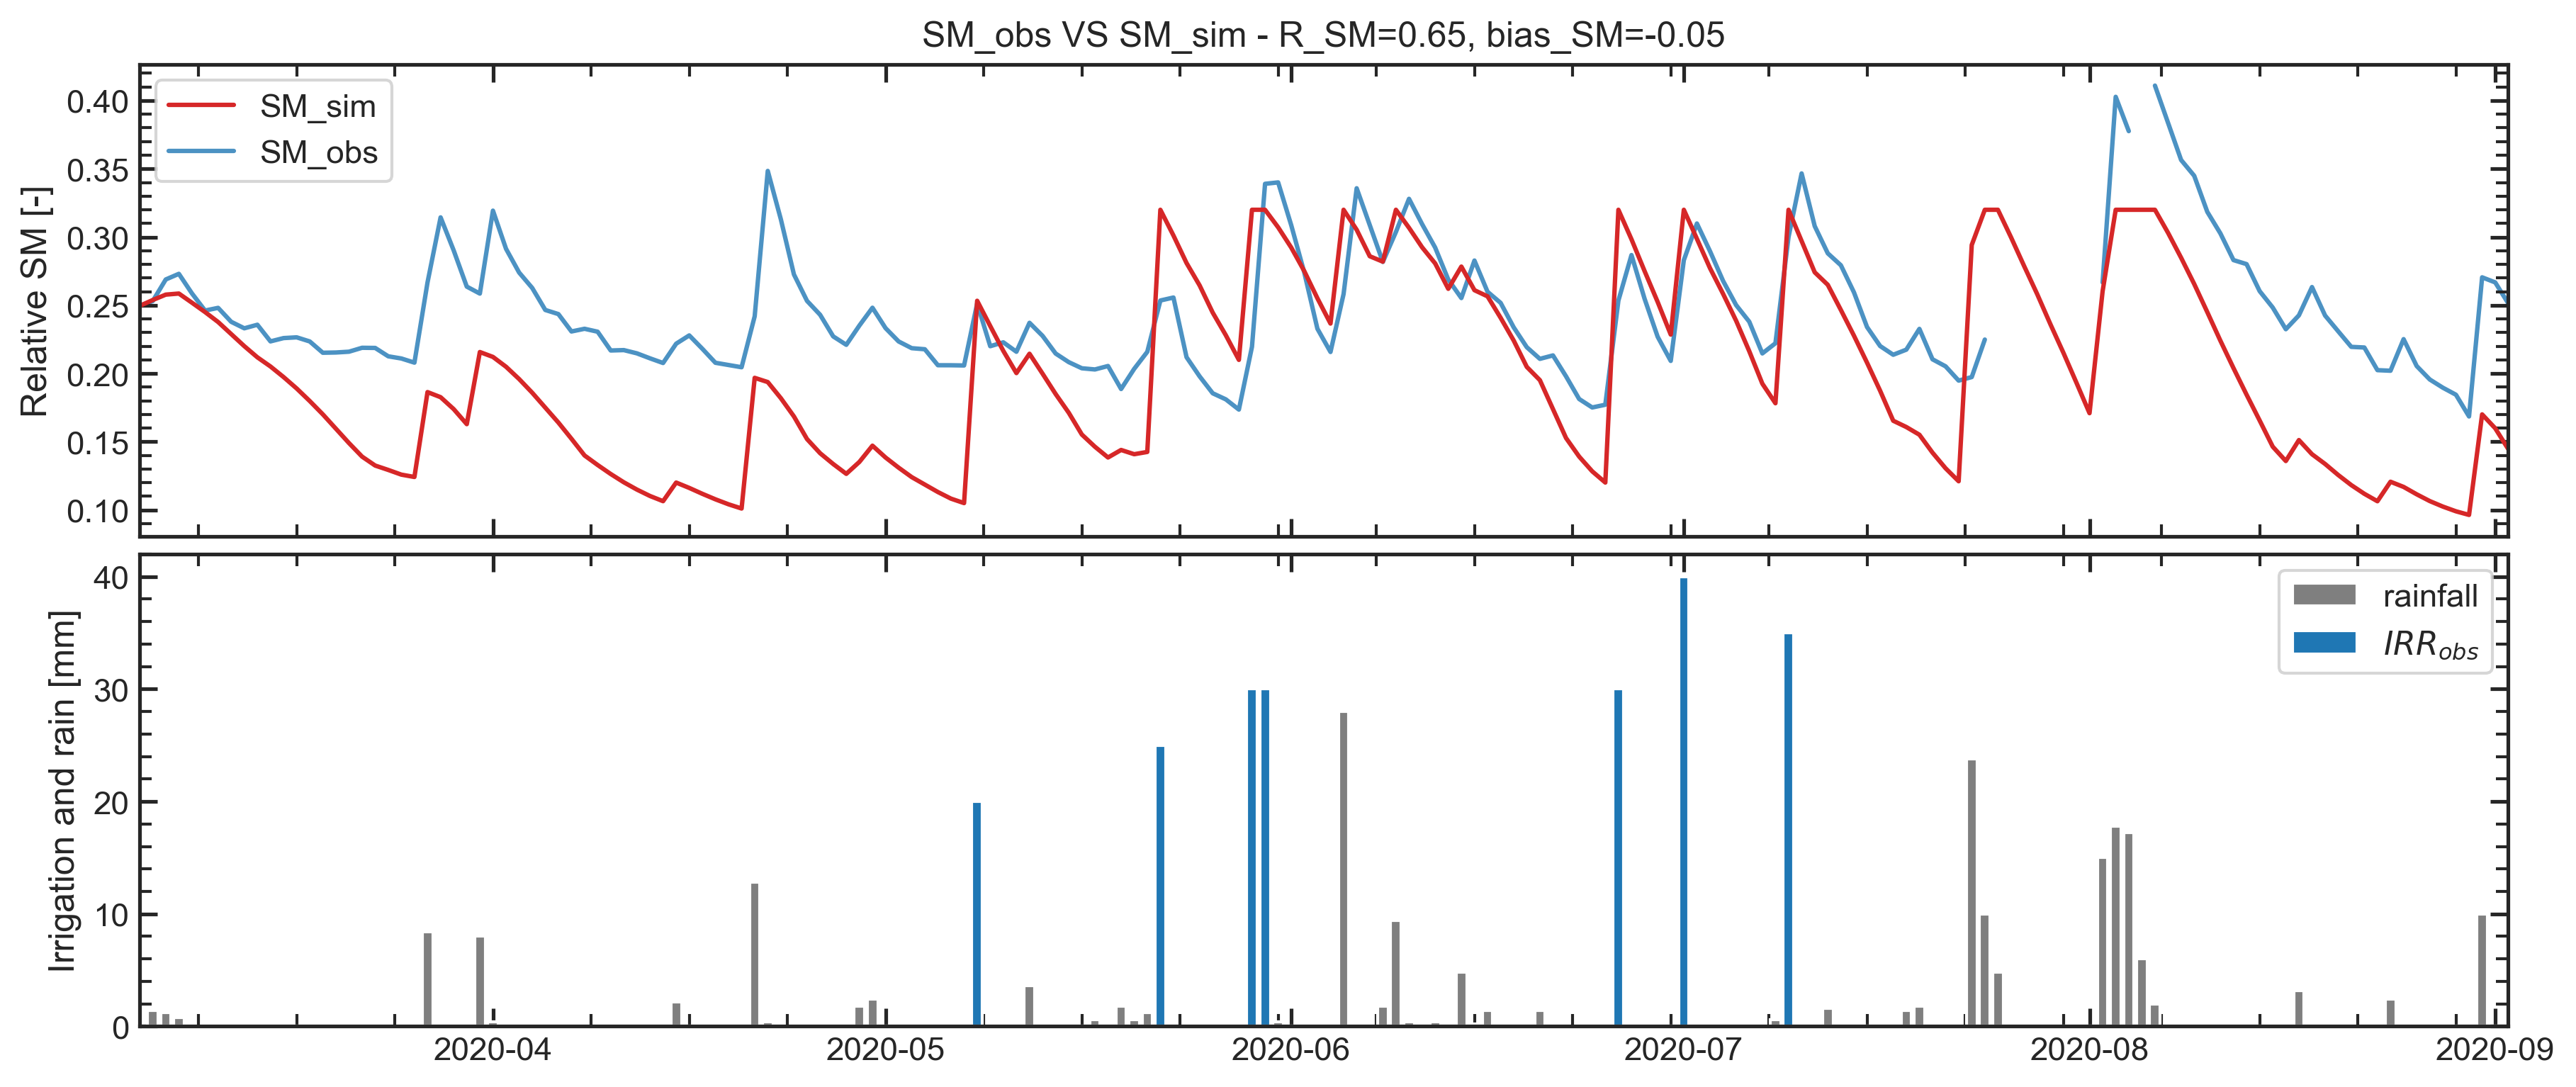

In [733]:
obs = WW_d; obs_label='SM_obs'
sim = WW; sim_label='SM_sim'

opt_save_plot = True if input('Save simulated VS observed soil moisture? [[]/(any)]')=='' else False

#-----------------------------------------------------------------------------
# Model performance on SM and plot
#-----------------------------------------------------------------------------
# RMSE, NS, R, bias calculation
RMSE=np.nanmean((sim-obs)**2)**0.5; print('RMSE =', RMSE)
NS=1-np.nansum((sim-obs)**2)/np.nansum((obs-np.nanmean(obs))**2); print('NS =', NS)
NS_radQ=1-np.nansum((np.sqrt(sim+0.00001)-np.sqrt(obs+0.00001))**2)/np.nansum((np.sqrt(obs+0.00001)-np.nanmean(np.sqrt(obs+0.00001)))**2)
NS_lnQ=1-np.nansum((np.log(sim+0.0001)-np.log(obs+0.0001))**2)/np.nansum((np.log(obs+0.0001)-np.nanmean(np.log(obs+0.0001)))**2)
NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
NS_radQ=NS_radQ.real; # print(NS_radQ)

simmatrix = np.array( [ [sim[i], obs[i]] for i in range(len(sim)) if not np.isnan(obs[i]) ] )
R=np.corrcoef(simmatrix,rowvar=False)[0][1]; print('R (sim vs obs) =', R)
B=bias(np.array([e[0] for e in simmatrix]), np.array([e[1] for e in simmatrix]))

if irri:
    IRRmatrix = np.array( [ [IRR[i], IRR_obs[i]] for i in range(len(IRR)) if not np.isnan(IRR_obs[i]) ] )
    R_IRR=np.corrcoef(IRRmatrix,rowvar=False)[0][1]; print('R_IRR (IRR vs IRR_obs)=', R_IRR)
    B_IRR=bias(np.array([e[0] for e in IRRmatrix]), np.array([e[1] for e in IRRmatrix]))
    irri_title = f'sumIRR_obs={np.sum(IRR_obs):.2f}, '+\
                 f'sumIRR_sim={np.sum(IRR):.2f}, '+\
                 f'R_IRR={R_IRR:.2f}, '+\
                 f'bias_IRR={B_IRR:.2f}, '
    
else: irri_title=''

fig, ax = plt.subplots(2, 1,constrained_layout=True,figsize=(12, 5), sharex=True,dpi=300,)

title=f'SM_obs VS SM_sim - '+f'{irri_title}'+\
    f'R_SM={R:.2f}, bias_SM={B:.2f}'

ax[0].set_xlim(xmin=d[0], xmax=d[len(d)-1])
ax[0].plot(d, sim, c='tab:red', label=sim_label)
ax[0].plot(d, obs, c='tab:blue', label=obs_label, linestyle='-', alpha=.8, zorder=-1)
ax[0].legend(loc='upper left')
ax[0].set_title(title)
ax[0].set_ylabel('Relative SM [-]')

ax[1].bar(d, P, color='tab:gray', label=r'rainfall')
ax[1].bar(d, IRR_obs, color='tab:blue', label=r'$IRR_{obs}$', zorder=2)
if irri: ax[1].bar(d, IRR, color='tab:red', label=r'$IRR_{sim}$', zorder=3)
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Irrigation and rain [mm]')

name=''
if opt_save_plot==True:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    name = filename+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    plt.savefig('Plot\\'+name+'.png')
    plt.show()
    plt.close()
    cost_history = optimizer.cost_history
    plot_cost_history(cost_history)
    plt.savefig('Plot\\'+name+'_cost'+'.png')

Save simulated VS observed soil moisture? [[]/(any)] n


RMSE = 1.9366547551197213
R= 0.5425249087582651
bias = -0.027372125025248672
KGE= 0.5414733570071748


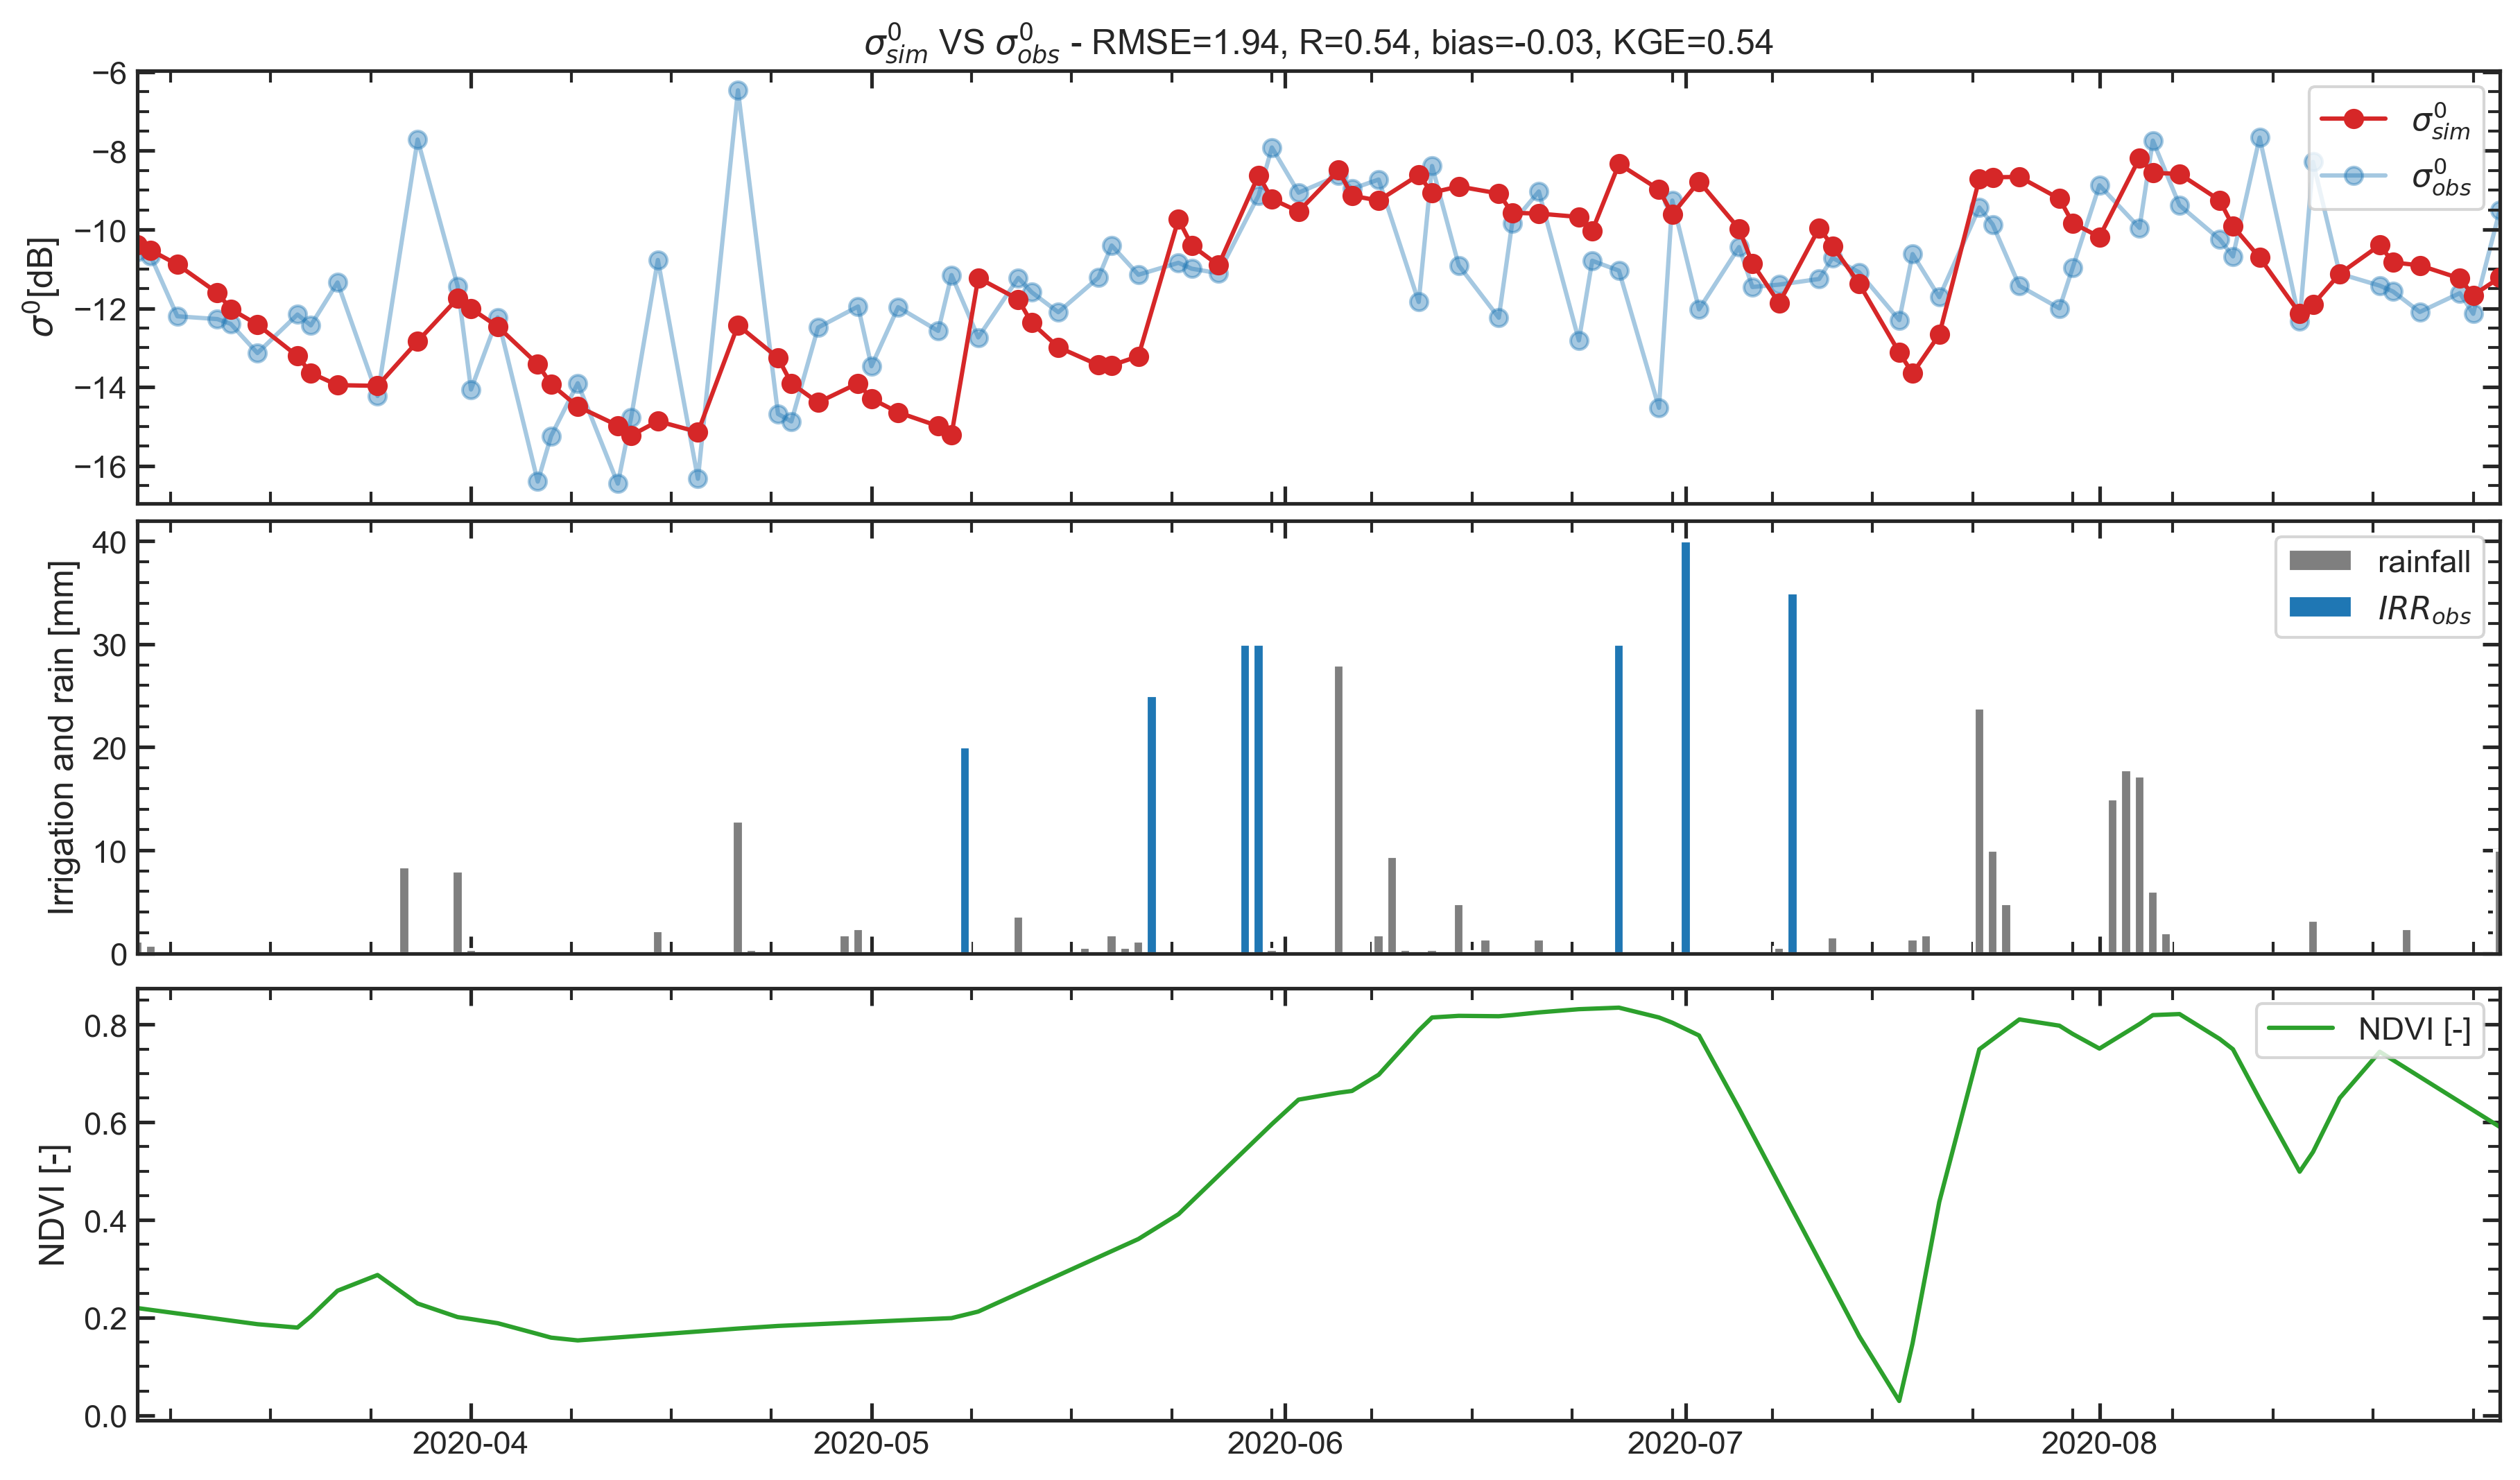

In [734]:
obs = VV; obs_label=r'$\sigma^0_{obs}$'
sim = sigma0; sim_label=r'$\sigma^0_{sim}$'
labely = r'$\sigma^0$[dB]'
times = d_sat
marker='o'; linestyle='-'

opt_save_plot = True if input('Save simulated VS observed soil moisture? [[]/(any)]')=='' else False

#-----------------------------------------------------------------------------
# Model performance on sigma0 and plot
#-----------------------------------------------------------------------------

# NS=1-np.nansum((q1-q2)**2)/np.nansum((q2-np.nanmean(q2))**2)
# NS_radQ=1-np.nansum((np.sqrt(q1+0.00001)-np.sqrt(q2+0.00001))**2)/np.nansum((np.sqrt(q2+0.00001)-np.nanmean(np.sqrt(q2+0.00001)))**2)
# NS_lnQ=1-np.nansum((np.log(q1+0.0001)-np.log(q2+0.0001))**2)/np.nansum((np.log(q2+0.0001)-np.nanmean(np.log(q2+0.0001)))**2)
# NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
# NS_radQ=NS_radQ.real; # print(NS_radQ)

RMSE=np.mean((sim-obs)**2)**0.5; print('RMSE =', RMSE)
R=np.corrcoef(sim,obs)[0][1]; print('R=', R)
B=bias(sim,obs); print('bias =', B)
print('KGE=', KGE[0])

fig, ax = plt.subplots(3, 1,constrained_layout=True,figsize=(12, 7), sharex=True,dpi=300,)

title=f'{sim_label} VS {obs_label} - RMSE={RMSE:.2f}, R={R:.2f}, bias={B:.2f}, KGE={KGE[0]:.2f}'

ax[0].set_xlim(xmin=times[0], xmax=times[len(times)-1])
ax[0].plot(times, sim, c='tab:red', label=sim_label,
           linestyle=linestyle, marker=marker, )#alpha=.4, zorder=-1)
ax[0].plot(times, obs, c='tab:blue', label=obs_label,
           linestyle=linestyle, marker=marker, alpha=.4, zorder=-1)
ax[0].legend(loc='upper right')
ax[0].set_title(title)
ax[0].set_ylabel(labely)

ax[1].bar(d, P, color='tab:gray', label=r'rainfall')
ax[1].bar(d, IRR_obs, color='tab:blue', label=r'$IRR_{obs}$', zorder=2)
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Irrigation and rain [mm]')

ax[2].plot(times, veg, label='NDVI [-]', color='tab:green')
ax[2].legend(loc='upper right')
ax[2].set_ylabel('NDVI [-]')

name=''
if opt_save_plot==True:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    name = filename+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    plt.savefig('Plot\\'+name+'sigma0.png')

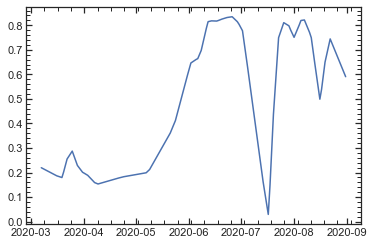

In [737]:
plt.plot(veg)

# Old inputs VS new inputs

# Snippets